# Data directory and globals

In [1]:
from pathlib import Path

# Define the directory containing the lens data (this is a private repository)
data_dir = Path('camflex-data/data')

# Define the output CSV file path
output_csv_path =Path('camflex-data/training_data.csv')

# Path to the PDF file containing the lens data
pdf_path = Path('lens_data.pdf')

# Define model_dir
model_dir = Path('models')

# Sanity check

In [2]:
import os

def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  isdir = os.path.isdir(path)
  if isdir:
    print(f"Directory '{path}' exists.")
  else:
    print(f"Directory '{path}' does not exist.")
  return os.path.isdir(path)

directory_exists(data_dir)
directory_exists(model_dir)

if os.path.isfile(output_csv_path):
  print(f"File '{output_csv_path}' exists.")
else:
  print(f"File '{output_csv_path}' does not exist.")

Directory 'camflex-data\data' exists.
Directory 'models' exists.
File 'camflex-data\training_data.csv' exists.


# Load existing training data

In [3]:
import pandas as pd

def load_training_data(output_csv_path):
  """Loads the training data from a CSV file.

  Returns:
    A DataFrame containing the training data.
  """
  return pd.read_csv(output_csv_path)

In [4]:
def printLensNames(data):
    # Get unique lens names
    unique_lens_names = data['LensName'].unique()

    # Report SensorW and SensorH for each unique lens name
    for cam in unique_lens_names:
        lens_data = data[data['LensName'] == cam]
        sensor_w = lens_data['FocalLength_cm'].unique()
        print(f"Camera: {cam} FocalLength: {sensor_w * 10}")

# Plot data to PDF

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def generate_lens_analysis_plots(data, pdf_path):
    """
    Generate and save scatter plots analyzing lens data to a PDF.

    Args:
        csv_training_data (DataFrame): Input data containing lens and camera details.
        pdf_path (str): File path to save the output PDF.
    """
    # Create a global color palette for consistent colors across all figures
    unique_camera_names = data['CameraName'].unique()
    color_mapping = dict(zip(unique_camera_names, sns.color_palette("colorblind", len(unique_camera_names))))

    # Open a PdfPages object to save figures
    with PdfPages(pdf_path) as pdf:
        lens_names = data['LensName'].unique()

        for lens_name in lens_names:
            plt.figure(figsize=(18, 12))  # Set figure size
            plt.suptitle(f'Data for Lens Name: {lens_name}', fontsize=14)

            # Filter data for the current lens name
            lens_data = data[data['LensName'] == lens_name]

            if lens_data.empty:
                continue  # Skip if no data for this lens

            # Create each subplot and rasterize it
            y_columns_titles = [
                ('K1', 'Distance vs K1'),
                ('K2', 'Distance vs K2'),
                ('U2', 'Distance vs U2'),
                ('V2', 'Distance vs V2'),
                ('U4', 'Distance vs U4'),
                ('V4', 'Distance vs V4')
            ]
            for idx, (y_col, title) in enumerate(y_columns_titles):
                plt.subplot(3, 2, idx + 1)
                sns.scatterplot(
                    data=lens_data,
                    x='Distance_cm',
                    y=y_col,
                    hue='CameraName',
                    palette=color_mapping,
                    s=10,
                    alpha=0.7,
                    legend=False  # Disable legend for subplots
                )
                plt.xscale('log')
                plt.xlabel('Distance (log scale)')
                plt.ylabel(y_col)
                plt.title(title)

                # Rasterize the subplot
                plt.gca().set_rasterized(True)

            # Create a single legend for the figure
            handles = [
                plt.Line2D([0], [0], marker='o', color=color_mapping[camera],
                           linestyle='', markersize=5) 
                for camera in unique_camera_names
            ]
            plt.figlegend(
                handles,
                unique_camera_names,
                title="Camera Name",
                loc='center left',
                bbox_to_anchor=(.85, 0.5),  # Adjust to position closer to the subplots
                borderaxespad=0,
            )

            # Adjust subplot spacing
            plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit legend
            plt.subplots_adjust(hspace=0.4, wspace=0.15)

            # Save the current figure to the PDF as a rasterized bitmap
            pdf.savefig(dpi=96)  # Specify DPI for bitmap quality
            plt.close()  # Close the figure to free memory

        print(f"All figures have been saved to {pdf_path}.")



# Visualize the parameter correlations

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlations(data):
    # Correlation matrix to check the relationships between the variables
    corr_matrix = data[['Distance_cm', 'K1', 'K2', 'U2', 'V2', 'U4', 'V4', 'SensorWidth_cm', 'SensorHeight_cm', 'FocalLength_cm']].corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='PiYG', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()



# Fixup the training data

In [7]:
def prepare_training_data(training_data, column_name, value_to_exclude):
    """
    Prepare the training data by:
    - Duplicating K1 and K2 columns to K1t and K2t
    - Extracting and removing rows where column_name equals value_to_exclude
    - Removing entries with insufficient data

    Args:
        training_data (pd.DataFrame): The original training data DataFrame.
        column_name (str): The name of the column to filter on.
        value_to_exclude (str): The value in the column to exclude from training_data.

    Returns:
        tuple: (updated_training_data, excluded_data)
    """
    # Duplicate the K1 and K2 columns as K1t and K2t
    training_data['K1t'] = training_data['K1']
    training_data['K2t'] = training_data['K2']

    # Extract the specified rows based on the column and value
    excluded_data = training_data[training_data[column_name] == value_to_exclude]

    # Update training_data to exclude the specified rows
    updated_training_data = training_data[training_data[column_name] != value_to_exclude]

    # Remove lenses with insufficient data
    lenses_to_remove = ['ZEISS_Supreme_040mm', 'ZEISS_Supreme_065mm']
    updated_training_data = updated_training_data[~updated_training_data['LensName'].isin(lenses_to_remove)]

    return updated_training_data, excluded_data




# Train, save and plot

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost
import onnxruntime as rt
from pathlib import Path
import numpy as np
import logging
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import logging
from itertools import product
import numpy as np


# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")



In [9]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnx import helper, load_model, save_model
from onnx.compose import add_prefix, merge_models
from io import BytesIO


def save_xgboost_to_onnx(k1_model, k2_model, model_path: Path, input_shape: int, feature_names: list, scaler):
    """
    Save separate XGBoost models for K1 and K2 to ONNX format, including scaler and feature labels in metadata.
    """
    if input_shape <= 0:
        raise ValueError("Input shape must be a positive integer.")

    if len(feature_names) != input_shape:
        raise ValueError("Feature names count must match input shape.")

    # Map custom feature names to 'f%d' format required by ONNX conversion
    generic_feature_names = [f"f{i}" for i in range(input_shape)]
    feature_name_mapping = dict(zip(generic_feature_names, feature_names))

    for model, suffix in zip([k1_model, k2_model], ["_k1", "_k2"]):
        # Ensure consistent opset version
        target_opset = 10

        # Convert the scaler to ONNX
        scaler_onnx = convert_sklearn(
            scaler, 
            initial_types=[('float_input', FloatTensorType([None, input_shape]))],
            target_opset=target_opset
        )

        # Convert the XGBoost model to ONNX
        model.get_booster().feature_names = generic_feature_names
        initial_type = [('float_input', FloatTensorType([None, input_shape]))]
        xgb_onnx = convert_xgboost(model, initial_types=initial_type, target_opset=target_opset)

        # Load and add prefixes to avoid collisions
        scaler_onnx_model = add_prefix(load_model(BytesIO(scaler_onnx.SerializeToString())), prefix="scaler_")
        xgb_onnx_model = add_prefix(load_model(BytesIO(xgb_onnx.SerializeToString())), prefix="xgb_")

        # Dynamically retrieve the tensor names
        scaler_output_name = scaler_onnx_model.graph.output[0].name  # First output of the scaler
        xgb_input_name = xgb_onnx_model.graph.input[0].name         # First input of the XGBoost model

        # Merge the two models
        combined_model = merge_models(
            scaler_onnx_model, 
            xgb_onnx_model, 
            io_map=[(scaler_output_name, xgb_input_name)]
        )

        # Add original feature names to metadata
        for generic_name, original_name in feature_name_mapping.items():
            combined_model.metadata_props.add(key=generic_name, value=original_name)

        # Save the combined model
        save_path = model_path.with_stem(model_path.stem + suffix)
        #save_path.parent.mkdir(parents=True, exist_ok=True)
        save_model(combined_model, save_path)
        logging.info(f"ONNX model saved at: {save_path}")


In [10]:
def prepare_data(data, features, targets):
    """
    Prepare data by extracting specified features and targets and dropping NaN rows.
    This function does not perform scaling.

    Args:
        data (pandas.DataFrame): The input dataset.
        features (list of str): List of feature column names.
        targets (list of str): List of target column names (e.g. ['K1t', 'K2t']).

    Returns:
        tuple: (X, y_k1, y_k2)
            X (numpy.ndarray): Feature matrix (not scaled).
            y_k1 (numpy.ndarray): Target values for first target.
            y_k2 (numpy.ndarray): Target values for second target.
    """
    if len(targets) != 2:
        raise ValueError("Expected exactly two target columns, e.g., ['K1t', 'K2t'].")
    
    # Extract only the columns we need and drop NaN values
    lens_data = data[features + targets].dropna()
    if lens_data.empty:
        raise ValueError("No valid data for training.")

    X = lens_data[features].values
    y_k1 = lens_data[targets[0]].values
    y_k2 = lens_data[targets[1]].values

    return X, y_k1, y_k2


In [11]:
def scale_data(X, scaler=None):
    """
    Scale the feature matrix X using a StandardScaler or a provided scaler.

    Args:
        X (numpy.ndarray): The feature matrix to be scaled.
        scaler (StandardScaler, optional): If provided, use this scaler.
                                          Otherwise, create and fit a new one.

    Returns:
        tuple: (X_scaled, scaler)
            X_scaled (numpy.ndarray): Scaled feature matrix.
            scaler (StandardScaler): The scaler used for transformation.
    """
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, scaler

In [12]:
def train_model(X, y, param_grid):
    """
    Trains an XGBoost model using a given parameter grid and returns the best model.
    Incorporates a train-validation split to ensure unbiased model selection.
    """
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=42)
    
    param_combinations = list(product(*param_grid.values()))
    param_keys = list(param_grid.keys())

    best_model = None
    best_score = float('inf')

    # Generate generic feature names for consistency with ONNX conversion
    feature_names = [f"f{i}" for i in range(X.shape[1])]

    for params in param_combinations:
        param_dict = dict(zip(param_keys, params))
        # Instantiate and train the model with the current set of hyperparameters
        model = xgb.XGBRegressor(eval_metric='rmse', random_state=42, early_stopping_rounds=10, **param_dict)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Assign feature names for potential ONNX conversion later
        model.get_booster().feature_names = feature_names

        # Predict on validation set and compute RMSE
        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

        # Check if this model is better than what we've found before
        if rmse < best_score:
            best_score = rmse
            best_model = model

    logging.info(f"Best validation RMSE: {best_score}")
    return best_model

In [13]:
def train_fl(data, features, targets, focal_length_to_train):
    """
    Trains models for each focal length (or a specific one if provided),
    and returns a dictionary with the trained models, scaler, and feature names for each focal length.
    This function does not save the models.
    """
    param_dict = {
        'max_depth': [3, 5],
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.01]
    }

    unique_focal_lengths = data['FocalLengthCommon_mm'].unique()

    # If a specific focal length is requested, filter the unique_focal_lengths
    if focal_length_to_train is not None:
        if focal_length_to_train not in unique_focal_lengths:
            raise ValueError(f"Specified focal length {focal_length_to_train} not found in data.")
        unique_focal_lengths = [focal_length_to_train]

    for focal_length in unique_focal_lengths:
        logging.info(f"Processing FocalLengthCommon_mm: {focal_length}")
        focal_data = data[data['FocalLengthCommon_mm'] == focal_length]

        # Prepare the data (no scaling here)
        X, y_k1, y_k2 = prepare_data(focal_data, features, targets)

        # Scale the features
        X_scaled, scaler = scale_data(X)

        # Train models on scaled features
        k1_model = train_model(X_scaled, y_k1, param_dict)
        k2_model = train_model(X_scaled, y_k2, param_dict)

    return k1_model, k2_model, scaler


In [14]:
import joblib

def save_trained_model(k1_model, k2_model, scaler, features, base_model_path, model_name):

    # Save ONNX model
    onnx_model_path = base_model_path / f"{model_name}.onnx"
    save_xgboost_to_onnx(
        k1_model=k1_model,
        k2_model=k2_model,
        model_path=onnx_model_path,
        input_shape=scaler.mean_.shape[0],  # Number of features
        feature_names=features,
        scaler=scaler
    )

    # Save joblib models and scaler
    k1_joblib_path = base_model_path / f"{model_name}_k1.joblib"
    k2_joblib_path = base_model_path / f"{model_name}_k2.joblib"
    scaler_joblib_path = base_model_path / f"{model_name}_scaler.joblib"

    joblib.dump(k1_model, k1_joblib_path)
    joblib.dump(k2_model, k2_joblib_path)
    joblib.dump(scaler, scaler_joblib_path)

    logging.info(f"Joblib model saved at: {k1_joblib_path}")
    logging.info(f"Joblib model saved at: {k2_joblib_path}")
    logging.info(f"Joblib model saved at: {scaler_joblib_path}")

    # Save XGBoost JSON models
    k1_xgb_path = base_model_path / f"{model_name}_k1.json"
    k2_xgb_path = base_model_path / f"{model_name}_k2.json"

    k1_model.get_booster().save_model(k1_xgb_path)
    k2_model.get_booster().save_model(k2_xgb_path)

    logging.info(f"XGBoost JSON model saved at: {k1_xgb_path}")
    logging.info(f"XGBoost JSON model saved at: {k2_xgb_path}")


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(data, k1_model, k2_model, scaler, features, targets, focal_length, fig_title=None):
    """
    Plot actual vs. predicted K1 and K2 values for a given focal length, including metrics (MAE, MSE, R², MSRE).

    Args:
        focal_length_data (dict): Dictionary containing models and scalers for each focal length.
                                 Format: {focal_length: {'k1_model': ..., 'k2_model': ..., 'scaler': ...}, ...}
        focal_length (int or float): The focal length to plot (e.g., 15, 50, etc.).
        data (pd.DataFrame): The dataset to filter for training data plots.
        features (list): List of feature column names.
        targets (list): List of target column names.

    Returns:
        None
    """
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        msre = np.mean(((y_true - y_pred) / y_true) ** 2) if np.all(y_true != 0) else np.nan  # Avoid division by zero
        return mae, mse, r2, msre

    # Filter data for the given focal length
    data_to_plot = data[data['FocalLengthCommon_mm'] == focal_length]

    # Prepare the data
    X, y_k1, y_k2 = prepare_data(data_to_plot, features, targets)

    # Scale the features
    X_scaled, _ = scale_data(X, scaler=scaler)

    # Predict K1 and K2
    k1_pred = k1_model.predict(X_scaled)
    k2_pred = k2_model.predict(X_scaled)

    # Calculate metrics
    k1_mae, k1_mse, k1_r2, k1_msre = calculate_metrics(y_k1, k1_pred)
    k2_mae, k2_mse, k2_r2, k2_msre = calculate_metrics(y_k2, k2_pred)

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if fig_title is not None:
        fig.suptitle(fig_title)

    # K1 plot
    axes[0].scatter(y_k1, k1_pred, alpha=0.7, label="Predictions")
    axes[0].plot([y_k1.min(), y_k1.max()], [y_k1.min(), y_k1.max()], 'r--', label="Ideal")
    axes[0].set_title("K1: Actual vs Predicted")
    axes[0].set_xlabel("Actual K1")
    axes[0].set_ylabel("Predicted K1")
    axes[0].legend()
    axes[0].text(0.05, 0.95, f"MAE: {k1_mae:.3f}\nMSE: {k1_mse:.3f}\nR²: {k1_r2:.3f}\nMSRE: {k1_msre:.3f}",
                 transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3))

    # K2 plot
    axes[1].scatter(y_k2, k2_pred, alpha=0.7, label="Predictions")
    axes[1].plot([y_k2.min(), y_k2.max()], [y_k2.min(), y_k2.max()], 'r--', label="Ideal")
    axes[1].set_title("K2: Actual vs Predicted")
    axes[1].set_xlabel("Actual K2")
    axes[1].set_ylabel("Predicted K2")
    axes[1].legend()
    axes[1].text(0.05, 0.95, f"MAE: {k2_mae:.3f}\nMSE: {k2_mse:.3f}\nR²: {k2_r2:.3f}\nMSRE: {k2_msre:.3f}",
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3))

    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd
import numpy as np

def TryOne(k1_model, k2_model, scaler, focal_length, k1, k2, sensor_width_cm, sensor_height_cm, distance_cm):
    # Create the test DataFrame
    X_test = pd.DataFrame({
        'FocalLengthCommon_mm': [focal_length],
        'K1': [k1],  # K1 source
        'K2': [k2],  # K2 source
        'SensorWidth_cm': [sensor_width_cm],
        'SensorHeight_cm': [sensor_height_cm],
        'Distance_cm': [distance_cm]
    })

    # Ensure scaler works with consistent input (convert to NumPy array)
    X_test_scaled = scaler.transform(X_test.values)

    # Predict 'k1' and 'k2'
    k1_predictions = k1_model.predict(X_test_scaled)
    k2_predictions = k2_model.predict(X_test_scaled)

    # Combine predictions into a NumPy array
    predictions = np.column_stack((k1_predictions, k2_predictions))

    # Display results
    results_df = pd.DataFrame(predictions, columns=['k1_predicted', 'k2_predicted'])
    print(results_df.to_string(index=False))


   Distance_cm        K1        K2        U2        U4        V2        V4  \
0         35.0  0.027107 -0.003056  0.000024 -0.000041  0.000346 -0.000283   
1         36.0  0.026009 -0.002892  0.000054 -0.000077  0.000358 -0.000301   
2         37.0  0.025037 -0.002715  0.000085 -0.000113  0.000371 -0.000319   
3         38.0  0.024064 -0.002542  0.000116 -0.000148  0.000384 -0.000337   
4         39.0  0.023143 -0.002355  0.000153 -0.000190  0.000397 -0.000356   

   SensorWidth_cm  SensorHeight_cm  FocalLength_cm  FocalLengthCommon_mm  \
0        2.022005          1.69513             1.5                    15   
1        2.022005          1.69513             1.5                    15   
2        2.022005          1.69513             1.5                    15   
3        2.022005          1.69513             1.5                    15   
4        2.022005          1.69513             1.5                    15   

              LensName        CameraName  PixelWidth  PixelHeight  \
0  ZE

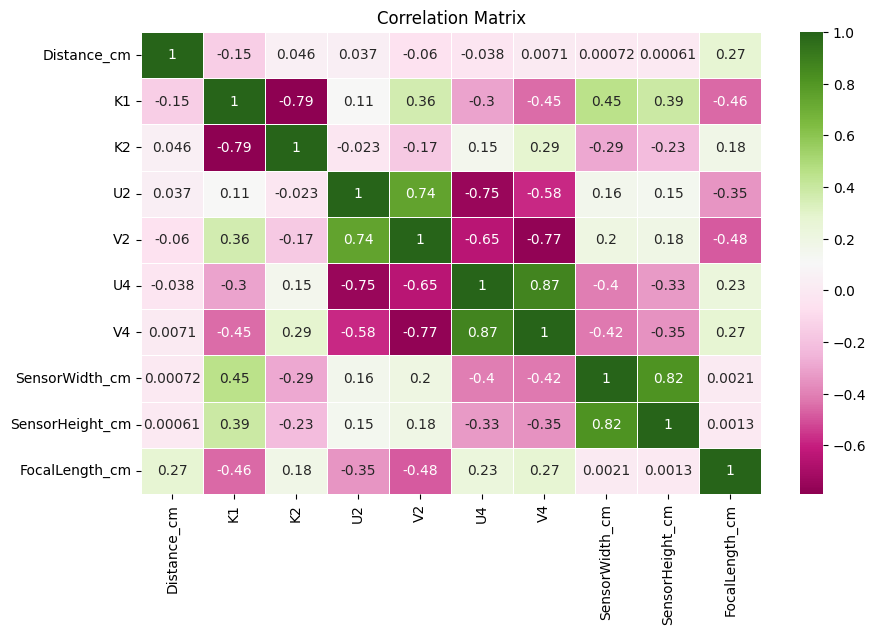

In [20]:
# Load the CSV file into a DataFrame
csv_data = load_training_data(output_csv_path)
print(csv_data.head())

plot_correlations(csv_data)


# PDF

In [ ]:
generate_lens_analysis_plots(csv_data, pdf_path)

All figures have been saved to output.pdf.


# Main

In [ ]:
training_data, hidden_data = prepare_training_data(csv_data, 'CameraName', 'Alexa35_OG')
print("Hidden data:")
print(hidden_data.head())
print("Training_data:")
print(training_data.head())

unique_lens_names = training_data['LensName'].unique()
print("Unique lens names:")
print(unique_lens_names)

unique_cam_names = training_data['CameraName'].unique()
print("Unique camera names:")
print(unique_cam_names)


2024-12-13 10:51:21,719 - INFO - Processing FocalLengthCommon_mm: 50
2024-12-13 10:51:22,229 - INFO - Best validation RMSE: 0.0008295212368858417
2024-12-13 10:51:22,495 - INFO - Best validation RMSE: 0.0016905968273725216


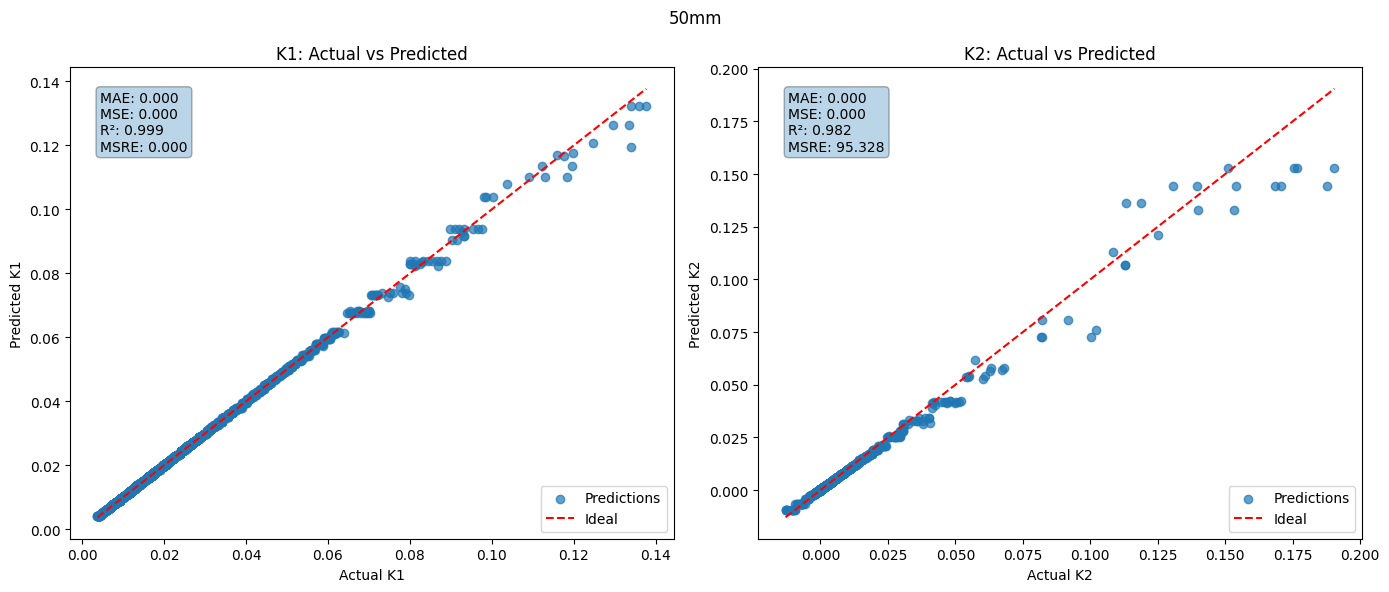

2024-12-13 10:51:22,894 - INFO - ONNX model saved at: models\50mm_k1.onnx
2024-12-13 10:51:22,974 - INFO - ONNX model saved at: models\50mm_k2.onnx
2024-12-13 10:51:22,981 - INFO - Joblib model saved at: models\50mm_k1.joblib
2024-12-13 10:51:22,982 - INFO - Joblib model saved at: models\50mm_k2.joblib
2024-12-13 10:51:22,982 - INFO - Joblib model saved at: models\50mm_scaler.joblib
2024-12-13 10:51:22,989 - INFO - XGBoost JSON model saved at: models\50mm_k1.json
2024-12-13 10:51:22,990 - INFO - XGBoost JSON model saved at: models\50mm_k2.json


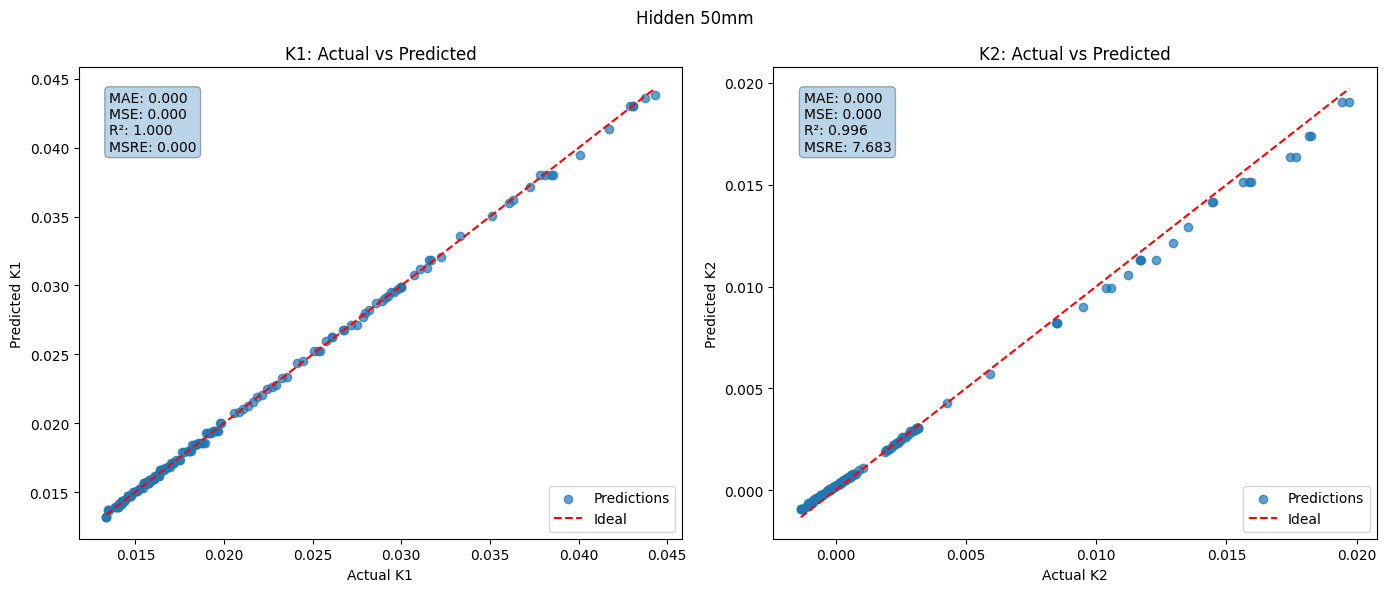

In [18]:

FEATURES = ['FocalLengthCommon_mm', 'K1', 'K2', 'SensorWidth_cm', 'SensorHeight_cm', 'Distance_cm']
TARGETS = ['K1t', 'K2t']

focal_length = 50

k1_model, k2_model, scaler = train_fl(training_data, FEATURES, TARGETS, focal_length)
plot_predictions(training_data, k1_model, k2_model, scaler, FEATURES, TARGETS, focal_length, fig_title=f"{focal_length}mm")
save_trained_model(k1_model, k2_model, scaler, FEATURES, model_dir, f"{focal_length}mm")

# Hidden data
plot_predictions(hidden_data, k1_model, k2_model, scaler, FEATURES, TARGETS, focal_length, fig_title=f"Hidden {focal_length}mm")


In [19]:

# Alexa35_OG
TryOne(k1_model, k2_model, scaler, focal_length, .1, .01, 2.799, 1.9218828124999998, 100)

 k1_predicted  k2_predicted
     0.115305      0.009456
